In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1.2,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 10, Accuracy: 0.808641975308642, Loss: 0.6078741991961444
Checkpoint 20, Accuracy: 0.8148148148148148, Loss: 0.5977661697952835
Checkpoint 30, Accuracy: 0.8641975308641975, Loss: 0.5278259559913918
Checkpoint 40, Accuracy: 0.8765432098765432, Loss: 0.5109381145901151
Checkpoint 50, Accuracy: 0.8888888888888888, Loss: 0.4932047526041667
Checkpoint 60, Accuracy: 0.8950617283950617, Loss: 0.4015636444091797
Checkpoint 70, Accuracy: 0.9197530864197531, Loss: 0.33778084648980033
Checkpoint 80, Accuracy: 0.9012345679012346, Loss: 0.3119919741595233
Checkpoint 90, Accuracy: 0.9506172839506173, Loss: 0.26499107148912215
Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.20183308919270834
Checkpoint 110, Accuracy: 0.9691358024691358, Loss: 0.17926413924605758
Checkpoint 120, Accuracy: 0.9814814814814815, Loss: 0.16657693297774703
Checkpoint 130, Accuracy: 0.9691358024691358, Loss: 0.14083405777260108
Checkpoint 140, Accuracy: 0.9567901234567902, Loss: 0.1502068660877369
Checkpoint

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [9.9794441e-01 1.3024327e-03 7.5312483e-04]
[1. 0. 0.] <-> [9.9774003e-01 1.5859711e-03 6.7398371e-04]
[1. 0. 0.] <-> [9.9780339e-01 1.2849681e-03 9.1158214e-04]
[1. 0. 0.] <-> [0.99683577 0.00150279 0.00166151]
[0. 0. 1.] <-> [0.6501216  0.00350581 0.34637254]
[0. 0. 1.] <-> [1.3579318e-02 2.8702131e-04 9.8613364e-01]
[1. 0. 0.] <-> [9.9580538e-01 3.4117638e-03 7.8271120e-04]
[1. 0. 0.] <-> [9.9724686e-01 1.9938927e-03 7.5925374e-04]
[1. 0. 0.] <-> [0.98728395 0.00236061 0.01035553]
[1. 0. 0.] <-> [9.9664658e-01 2.5701057e-03 7.8328344e-04]
[1. 0. 0.] <-> [9.9799877e-01 1.2815438e-03 7.1970845e-04]
[1. 0. 0.] <-> [0.78585285 0.00308211 0.21106502]
[1. 0. 0.] <-> [0.99492115 0.00155004 0.00352887]
[0. 1. 0.] <-> [7.2072130e-03 9.9262637e-01 1.6636365e-04]
[1. 0. 0.] <-> [0.99702567 0.00159999 0.00137426]
[1. 0. 0.] <-> [9.9790204e-01 1.4706259e-03 6.2742503e-04]
[1. 0. 0.] <-> [0.9926307  0.00137227 0.00599702]
[1. 0. 0.] <-> [0.43877116 0.00184274 0.55938613]
[0. 0. 1.]

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

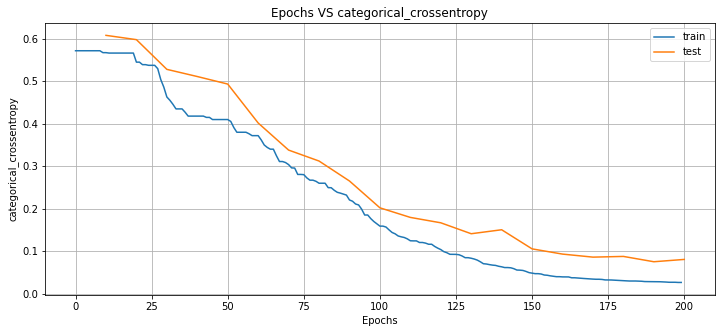

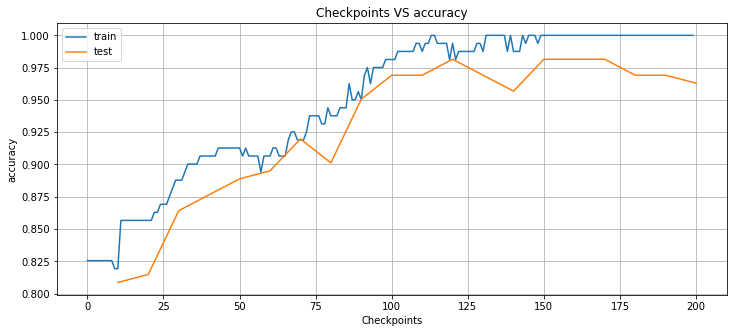

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.808641975308642, 'mean_square_error': 0.3880096618770675, 'categorical_crossentropy': 0.6078741991961444, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 31, 'tn_hit': 1, 'fn_hit': 0}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 16}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 10} 


{'accuracy': 0.8148148148148148, 'mean_square_error': 0.37237701629370934, 'categorical_crossentropy': 0.5977661697952835, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 30, 'tn_hit': 2, 'fn_hit': 0}, 1: {'tp_hit': 2, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 15}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}}, 'checkpoint': 20} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 0.310378917587954, 'categorical_crossentropy': 0.5278259559913918, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 18, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 10, 'fp_hit': 3, 'tn_hit': 88, 'fn_hit': 7}, 2: {'tp_hit': 3, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit'

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.5750157 -3.        -0.7077033  0.624357   3.       ]
 bias: -3.0

Neuron 1: weights:
[-0.49576604  3.          1.7014208  -2.892897   -0.9143925 ]
 bias: 3.0

Neuron 2: weights:
[ 0.9182439  -2.2716737  -1.817697   -0.69760406  3.        ]
 bias: 3.0

Neuron 3: weights:
[-1.9436743   3.          2.596569    1.325744   -0.34832737]
 bias: -3.0

$
Layer 2
Neuron 0: weights:
[-3.         3.         3.        -2.9619675]
 bias: 0.11092476546764374

Neuron 1: weights:
[-2.315645    0.50376016 -3.          3.        ]
 bias: 1.5706552267074585

Neuron 2: weights:
[ 3.         -3.          0.66184783 -1.3561367 ]
 bias: 0.7365046739578247

$

